In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# each run create a new writer with its own dir
# so that for each run, new curves are plotted instead of append to old curves
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
now = datetime.now()
logdir = "runs/" + now.strftime("%Y%m%d-%H%M%S") + "/"
writer = SummaryWriter(logdir)

In [2]:
# # loop thru folds
# for i in range(5):
#     # loop thru epoch
#     for e in range(100):
#         writer.add_scalars('train_loss', {'fold{}'.format(i):np.random.random()}, e)

### Read in the entire dataset

In [3]:
civilwar_data = 'data/civilwar.csv'
cw = pd.read_csv(civilwar_data) 
cw

,Unnamed: 0,atwards,X,id,cid,cowcode,year,warstds,ptime,yrint,...,decade1,decade2,decade3,decade4,independ,tip,anocracy,proxregc,sxpnew.2,sxpsq.2
0,1,0,1,1.0,1,700,1945,0,12,0,...,0,0,0,0,1,17.000000,0,1.432991e-01,0.094095,0.094095
1,2,0,2,1.0,1,700,1946,0,24,1,...,0,0,0,0,1,18.000000,0,1.000000e+00,0.094547,0.094547
2,3,0,3,1.0,1,700,1947,0,36,2,...,0,0,0,0,1,19.000000,0,1.000000e+00,0.095567,0.095567
3,4,0,4,1.0,1,700,1948,0,48,3,...,0,0,0,0,1,20.000000,0,1.000000e+00,0.101303,0.101303
4,5,0,5,1.0,1,700,1949,0,60,4,...,0,0,0,0,1,21.000000,0,1.000000e+00,0.092107,0.092107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7135,7136,0,9628,161.0,172,552,1996,0,280,30,...,0,0,0,1,1,8.000000,0,1.530000e-05,0.259141,0.259141
7136,7137,0,9629,161.0,172,552,1997,0,292,31,...,0,0,0,1,1,9.000000,0,3.810000e-06,0.452436,0.452436
7137,7138,0,9630,161.0,172,552,1998,0,304,32,...,0,0,0,1,1,10.000000,0,9.540000e-07,0.097356,0.097356
7138,7139,0,9631,161.0,172,552,1999,0,316,33,...,0,0,0,1,1,11.000000,0,2.380000e-07,0.090076,0.090076


### Select only the variables specified in Sambanis (2006) Appendix, as the paper did

In [4]:
cols = ["warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
        "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
        "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel",
        "durable", "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590",
        "expgdp", "exrec", "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2",
        "geo34", "geo57", "geo69", "geo8", "illiteracy", "incumb", "infant",
        "inst", "inst3", "life", "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper",
        "mirps0", "mirps1", "mirps2", "mirps3", "nat_war", "ncontig",
        "nmgdp", "nmdp4_alt", "numlang", "nwstate", "oil", "p4mchg",
        "parcomp", "parreg", "part", "partfree", "plural", "plurrel",
        "pol4", "pol4m", "pol4sq", "polch98", "polcomp", "popdense",
        "presi", "pri", "proxregc", "ptime", "reg", "regd4_alt", "relfrac", "seceduc",
        "second", "semipol3", "sip2", "sxpnew", "sxpsq", "tnatwar", "trade",
        "warhist", "xconst"]
cw_91 = cw.loc[:, cols]
print(cw_91.shape)
cw_91.head()

(7140, 91)


,warstds,ager,agexp,anoc,army85,autch98,auto4,autonomy,avgnabo,centpol3,...,seceduc,second,semipol3,sip2,sxpnew,sxpsq,tnatwar,trade,warhist,xconst
0,0,34.461765,8.510845,0,129472.9042,0,3.925812,0.005151,0.432955,1,...,43.770298,0.253,0.058441,0.46176,0.158275,0.052989,0.443259,72.881375,0,3.995912
1,0,34.346348,8.478997,0,129413.0225,0,10.000000,0.000000,0.045052,1,...,43.588363,0.253,0.000000,0.00000,0.158321,0.052663,1.000000,72.900089,0,1.000000
2,0,77.000000,8.481015,0,130431.0145,0,10.000000,0.000000,0.030034,1,...,43.538181,0.253,0.000000,0.00000,0.158425,0.052891,2.000000,72.962880,0,1.000000
3,0,78.000000,8.451628,0,126781.6866,0,10.000000,0.000000,0.022526,1,...,43.490005,0.253,0.000000,0.00000,0.159006,0.052902,2.000000,73.102449,0,1.000000
4,0,79.000000,8.500172,0,130979.2470,0,10.000000,0.000000,0.022526,1,...,43.602238,0.253,0.000000,0.00000,0.158074,0.052706,2.000000,72.850389,0,1.000000


### Define train and test datasets

- We attempt both the model using all 285 variables and the model using only 90 variables which were used in the civil war onset paper
- Two models have different predictive variables, so the `X`s are different. The labels are the same, so the `y`s are the same.

In [5]:
X_285 = cw.iloc[:, 1:] # use all 285 variables to predict
X_90 = cw_91.iloc[:, 1:] # only use 90 varaibles to predict
y = cw_91.iloc[:, 0] # 

# Since we have imbalanced dataset, it is important to stratify our train test split so that the ratios between
# different classes are the same (or close to same) in train and test set.
X_train_285, X_test_285, y_train, y_test = train_test_split(X_285, y, test_size=0.33, random_state=69, stratify=y)
X_train_90, X_test_90, y_train, y_test = train_test_split(X_90, y, test_size=0.33, random_state=69, stratify=y)

### Define data loaders to train in batches

In [6]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)


BATCH_SIZE = 64    
train_data_90 = trainData(torch.FloatTensor(X_train_90.to_numpy()), torch.FloatTensor(y_train.to_numpy()))
test_data_90 = testData(torch.FloatTensor(X_test_90.to_numpy()))
train_loader_90 = DataLoader(dataset=train_data_90, batch_size=BATCH_SIZE, shuffle=True)
test_loader_90 = DataLoader(dataset=test_data_90, batch_size=1)

train_data_285 = trainData(torch.FloatTensor(X_train_285.to_numpy()), torch.FloatTensor(y_train.to_numpy()))
test_data_285 = testData(torch.FloatTensor(X_test_285.to_numpy()))
train_loader_285 = DataLoader(dataset=train_data_285, batch_size=BATCH_SIZE, shuffle=True)
test_loader_285 = DataLoader(dataset=test_data_285, batch_size=1)

### Define the NN architectures

- Because we are using the `BCEWithLogitsLoss`, the activation function of the last layer -- the logit function is applied when calculating the loss. 
- **An important consequence of this is the output of this NN can be interpreted as the the probability of y=1.**
- `Dropout` is applied to reduce overfitting
- `Batchnorm` is applied to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. 

In [34]:
class binaryNN90(nn.Module):
    def __init__(self):
        super(binaryNN90, self).__init__()
        # 90 input features
        self.layer_1 = nn.Linear(90, 64) 
        self.layer_2 = nn.Linear(64, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.batchnorm3 = nn.BatchNorm1d(16)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        #x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.layer_out(x)
        
        return x

    
### this NN uses all 285 features    
class binaryNN285(nn.Module):
    def __init__(self):
        super(binaryNN285, self).__init__()
        # 90 input features
        self.layer_1 = nn.Linear(285, 124) 
        self.layer_2 = nn.Linear(124, 64)
        #self.layer_3 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(124)
        self.batchnorm2 = nn.BatchNorm1d(64)
        #self.batchnorm3 = nn.BatchNorm1d(32)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        #x = self.relu(self.layer_3(x))
        #x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

### Train the model

In [8]:
def binary_acc(y_score, y_test):
    y_pred = torch.round(torch.sigmoid(y_score))

    correct_results_sum = (y_pred == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

#### Function for training for one epoch

In [9]:
def train(device, criterion, model, optimizer, train_loader):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_score = model(X_batch)
        
        loss = criterion(y_score, y_batch.unsqueeze(1))
        acc = binary_acc(y_score, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    avg_loss = epoch_loss/len(train_loader)
    avg_acc = epoch_acc/len(train_loader)
    
    #print(f'Epoch {e+0:03}: | Loss: {avg_loss:.5f} | Acc: {avg_acc:.3f}')
    # plot loss/acc vs. epoch plot on tensor board
    #writer.add_scalar("train_loss", avg_loss, e)
    #writer.add_scalar("train_accuracy", avg_acc, e)
    
    return avg_loss, avg_acc


#### Function for evaluating a model

In [10]:
def val(model, test_loader):
    y_score_list = []
    y_pred_list = []
    model.eval()
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            # predicted probabilities of y=1
            y_score = torch.sigmoid(model(X_batch))
            #display(y_score)
            y_score_list.append(y_score.cpu().numpy())
            # predicted labels
            y_pred = torch.round(y_score)
            y_pred_list.append(y_pred.cpu().numpy())

    y_score_list = [a.squeeze().tolist() for a in y_score_list]
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    return y_score_list, y_pred_list

# y_score_list, y_pred_list = val(model, test_loader_90)
# print(len(y_score_list))
# print(y_pred_list)

In [11]:
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

### configure device, loss function and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()
model = binaryNN90()
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# specify that we are in the training mode.
# This is important since dropout and batchnorm layers behave differently in training and testing phase
model.train()

for e in range(1, NUM_EPOCHS+1):
    train(device=device, model=model, criterion=criterion, optimizer=optimizer, train_loader=train_loader_90)

binaryNN90(
  (layer_1): Linear(in_features=90, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Train and Test the NN's performance using 10-fold crossvalidation

`X`, `y` are tensors

In [21]:
def crossvali_roc_showall(X, y, n_splits, n_epoch, optimizer, model_type, criterion):
    
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits, shuffle=True, random_state=666)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, ax = plt.subplots(figsize=(15, 12))
    
    # configure the model
    LEARNING_RATE = 0.001
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = nn.BCEWithLogitsLoss()
    
    # loop thru all the folds
    for i, (tr_index, te_index) in enumerate(cv.split(X, y)):
        
        #init the model
        if model_type == '90':
            model = binaryNN90()
        else:
            model = binaryNN285()
        model.to(device)
        print(model)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        
        ### set up train test data ###
        X_tr, X_te = X.iloc[tr_index], X.iloc[te_index]
        y_tr, y_te = y.iloc[tr_index], y.iloc[te_index]       
        # convert dataframes to tensors to create dataloaders
        #trainData(torch.FloatTensor(X_train_90.to_numpy()), torch.FloatTensor(y_train.to_numpy()))
        trainset = trainData(torch.FloatTensor(X_tr.to_numpy()), torch.FloatTensor(y_tr.to_numpy()))
        testset = testData(torch.FloatTensor(X_te.to_numpy()))
        train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(testset, batch_size=1, shuffle=True)
        
        ### train the NN for one fold and get back the probabilities of yi=1 ###        
        for e in range(1, n_epoch+1):
            avg_loss, avg_acc = train(device=device, model=model, criterion=criterion, 
                  optimizer=optimizer, train_loader=train_loader)
            #print(f'Epoch {e+0:03}: | Loss: {avg_loss:.5f} | Acc: {avg_acc:.3f}')
            writer.add_scalars('training loss NN{}'.format(model_type), {'fold {}'.format(i): avg_loss}, e)
            writer.add_scalars('training accuracy NN{}'.format(model_type), {'fold {}'.format(i): avg_acc}, e)
            
        # scorelist denotes the predicted probablity of yi=1 (yi belongs to the positive class)
        y_score_list, y_pred_list = val(model, test_loader)
        #print(y_te.shape)
        #print(y_score_list)
        fpr, tpr, thresholds = roc_curve(y_te, np.array(y_score_list))
        ax.plot(fpr, tpr, label='fold {}'.format(i), lw=2, alpha=.8)

        # interpolate to get smoother curve
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    # plot the mean 
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label='mean ROC with AUC = {:.3f}'.format(mean_auc),
        lw=4, alpha=0.8)
    
    # fill the area within one standard deviation
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    ax.legend()

    
    return mean_fpr, mean_tpr, mean_auc, std_auc

binaryNN90(
  (layer_1): Linear(in_features=90, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
binaryNN90(
  (layer_1): Linear(in_features=90, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=

(array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.72727273, 0.73

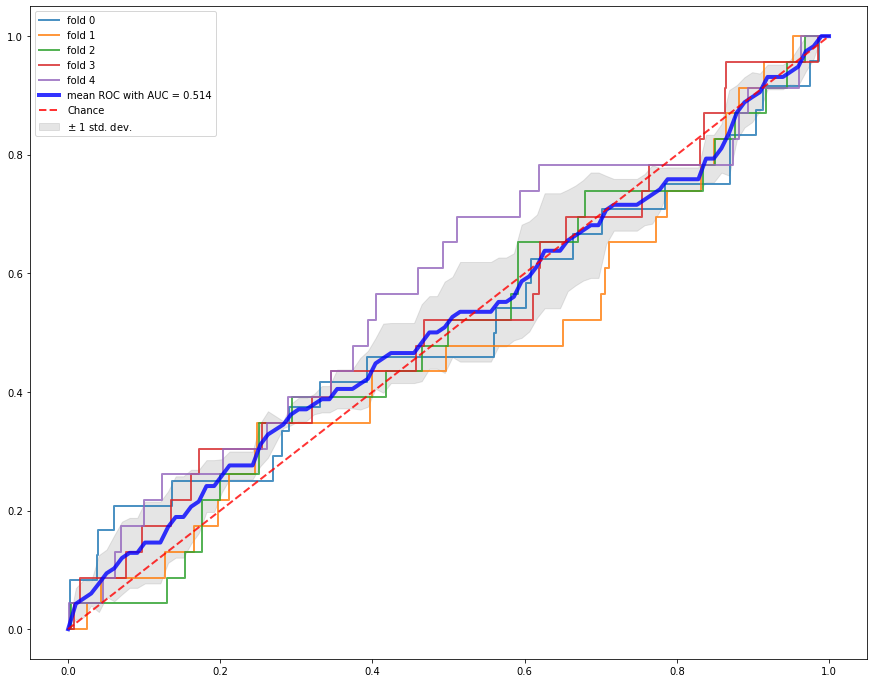

In [30]:
crossvali_roc_showall(X=X_90, y=y, n_splits=5, n_epoch=250, optimizer=optimizer, 
                      model_type='90', criterion=criterion)

binaryNN285(
  (layer_1): Linear(in_features=285, out_features=124, bias=True)
  (layer_2): Linear(in_features=124, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
binaryNN285(
  (layer_1): Linear(in_features=285, out_features=124, bias=True)
  (layer_2): Linear(in_features=124, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
binaryNN285(
  (layer_1): Linear(in_features=285, out_features=124, bias

(array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.72727273, 0.73

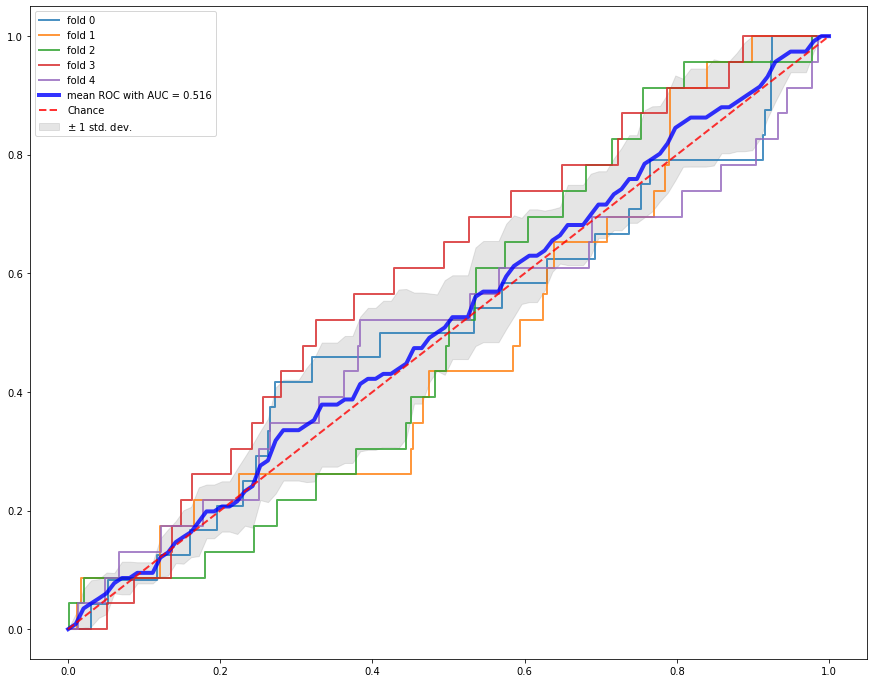

In [35]:
crossvali_roc_showall(X=X_285, y=y, n_splits=5, n_epoch=250, optimizer=optimizer, 
                      model_type='285', criterion=criterion)